In [37]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import sqlite3

In [53]:
warnings.filterwarnings('ignore')

competitions = pd.read_csv('Football data/competitions.csv')
appearances = pd.read_csv('Football data/appearances.csv')
club_games = pd.read_csv('Football data/club_games.csv')
clubs = pd.read_csv('Football data/clubs.csv')
game_events = pd.read_csv('Football data/game_events.csv')
game_lineups = pd.read_csv('Football data/game_lineups.csv')
games = pd.read_csv('Football data/games.csv')
players = pd.read_csv('Football data/players.csv')
player_values = pd.read_csv('Football data/player_valuations.csv')

In [54]:
#For later comparison with other clubs
game = games
club = clubs
player_value = player_values
appearance = appearances

In [55]:
club_name = "Real Madrid" #The main name of your team e.g. Tottenham, Leipzig,...
season = 2023 #The season you want to analyze

#Club ID
clubs = clubs[clubs['name'].str.contains(club_name, case=False)]
club_id = clubs[clubs['name'].str.contains(club_name, case=False)]['club_id'].iat[0]

#Their Domestic League ID 
league_id = clubs['domestic_competition_id'].iat[0]

#Get the country of the club
club_country = competitions[competitions['competition_id'] == league_id]['country_name'].iat[0]

print(f"Club ID: {club_id}")
print(f"League ID: {league_id}")
print(f"Country: {club_country}")


Club ID: 418
League ID: ES1
Country: Spain


In [41]:
cursor = connection.cursor()

# Parameters
club_name = "Real Madrid"
season = 2023

# Fetch club_id and league_id
cursor.execute("""SELECT club_id, domestic_competition_id 
               FROM clubs 
               WHERE name 
               LIKE ? COLLATE NOCASE""", ('%' + club_name + '%',))
row = cursor.fetchone()
if row:
    club_id, league_id = row
else:
    print("Club not found")

# Fetch country
cursor.execute("""SELECT country_name 
               FROM competitions 
               WHERE competition_id = ?""", (league_id,))
row = cursor.fetchone()
if row:
    club_country = row[0]
else:
    print("Country not found")

# Print results
print(f"Club ID: {club_id}")
print(f"League ID: {league_id}")
print(f"Country: {club_country}")

Club ID: 418
League ID: ES1
Country: Spain


Now we want to clean the appearances table and get all the appearances of players at the club by getting all the rows with players who have id of the club. It's not necessary to be in this season because we will filter when we use it later, now it can be used for players who have played for the club:

In [58]:
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['season'] = appearances['date'].apply(lambda x: f'{x.year}-{x.year + 1}' if x.month >= 8 else f'{x.year - 1}-{x.year}')
appearances['season_start_year'] = appearances['season'].str.split('-').str[0].astype(int)
appearances['season_end_year'] = appearances['season'].str.split('-').str[1].astype(int)
appearances['season_start_month_year'] = appearances['season_start_year'].apply(lambda x: f"08 {x}")

appearances[['player_id', 'player_club_id', 'player_name', 'season', 'season_start_year', 'season_end_year']].head()

,player_id,player_club_id,player_name,season,season_start_year,season_end_year
0,38004,853,Aurélien Joachim,2011-2012,2011,2012
1,79232,8841,Ruslan Abyshov,2011-2012,2011,2012
2,42792,6251,Sander Puri,2011-2012,2011,2012
3,73333,1274,Vegar Hedenstad,2011-2012,2011,2012
4,122011,195,Markus Henriksen,2011-2012,2011,2012


Next, we want to get all the domestic games of this season by getting all the game ids occurred in that season and filter tables:

In [59]:
#Get all domestic games in that season
games['date'] = pd.to_datetime(games['date'])
games = games[((games['home_club_id'] == club_id) | (games['away_club_id'] == club_id)) & (games['season'] == season)]
games_id = games[games['competition_id'] == league_id].sort_values(by='round')['game_id'].tolist()
domestic_game = games[games['competition_id'] == league_id].sort_values(by='date')

#Create an extra column which calculates the number of goals in a match
club_games = club_games[((club_games['club_id'] == club_id)) & (club_games['game_id'].isin(games_id))]
club_games['total_goals'] = club_games['own_goals'] + club_games['opponent_goals']
club_games['clean_sheets'] = club_games.apply(
    lambda row: 1 if (row['opponent_id'] == 148 and row['own_goals'] == 0) | (row['club_id'] == 148 and row['opponent_goals'] == 0) else 0,
    axis=1
)

game_events = game_events[(game_events['club_id'] == club_id ) & (game_events['game_id'].isin(games_id))]
game_lineups = game_lineups[(game_lineups['club_id'] == club_id ) & (game_lineups['game_id'].isin(games_id))]
game_lineups.head()

,game_lineups_id,game_id,club_id,type,number,player_id,player_name,team_captain,position
2221603,5816b393dfb7a89be6c163660e8d2757,4112806,418,substitutes,10,27992,Luka Modric,0,Attacking Midfield
2221604,fdc40c84dc5ff1a1c39a6601b9479485,4112806,418,substitutes,8,31909,Toni Kroos,0,Central Midfield
2221607,970e8734338c1dc6997eef3c597418c4,4112806,418,substitutes,6,58884,Nacho Fernández,0,Centre-Back
2221608,b53efba0d24361dff1da084018db059c,4112806,418,starting_lineup,4,59016,David Alaba,0,Centre-Back
2221609,f083c8c13eb0953f69c38575ef577ec7,4112806,418,substitutes,14,81999,Joselu,0,Centre-Forward


In [62]:
#Get all players in the season
appearances = appearances[appearances['player_club_id'] == club_id]
appearances = appearances[(appearances['game_id'].isin(games_id)) & (appearances['player_club_id'] == club_id)]
get_all_players = set(appearances['player_id'].to_list())

#Make an categorical order for the positions
order = ['Goalkeeper', 'Defender', 'Midfield', 'Attack']
players['position'] = pd.Categorical(players['position'], categories=order, ordered=True)
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['is_foreigner'] = np.where(players['country_of_citizenship'] != club_country, 1, 0)
players['age'] = season - players['date_of_birth'].dt.year

player_values['date'] = pd.to_datetime(player_values['date'])
player_values['month_year'] = player_values['date'].apply(lambda x: f"08 {x.year}" if x >= pd.Timestamp(x.year, 7, 1) else f"08 {x.year-1}")
player_values['season'] = player_values['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x >= pd.Timestamp(x.year, 7, 1) else f"{x.year-1}-{x.year}")
player_values = player_values.loc[player_values.groupby(['player_id','season'])['date'].idxmin()] #Get value only at start of season

players_current_season = players[players['player_id'].isin(get_all_players)]
players_current_season['season_start'] = f'08 {season}'

#Get the value of the following season
players_current_season = players_current_season.merge(player_values[['player_id', 'market_value_in_eur', 'month_year']], 
                left_on=['season_start', 'player_id'], right_on=['month_year', 'player_id'])
attribute = ['name', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'foot', 'height_in_cm', 'market_value_in_eur_y'] #Attribute for the display the players

players.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,is_foreigner,age
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,1,45.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0,1,43.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,1,42.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0,1,45.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0,1,42.0


Club Information

In [63]:
name = clubs['name'].iat[0]
stadium = clubs['stadium_name'].iat[0]
attendance = clubs['stadium_seats'].iat[0]
print(f'{name} plays in {stadium} with {attendance} seats\n')

'''Coach'''
a = set(club_games[club_games['club_id'] == club_id]['own_manager_name'].tolist())
b = set(club_games[club_games['opponent_id'] == club_id]['opponent_manager_name'].tolist())
coach = list(set(a|b))
if len(coach) == 1:
    coach = coach[0]
print(f'Manager in {season}/{season+1} season is {coach}\n')

'''Total market value'''
total_market_value = players_current_season['market_value_in_eur_y'].sum()
print(f'In {season}/{season+1} the club has a total market value of {total_market_value}€\n')

'''Most valuable player'''
mvp = players_current_season[attribute][players_current_season['market_value_in_eur_y'] == players_current_season['market_value_in_eur_y'].max()]
print(f"Most valuable player of the team:\n{mvp}\n")

'''Average Age, oldest, youngest players'''
avg_age = players_current_season['age'].mean()
print(f'Average age of the team is {round(avg_age, 2)} years old\n')

oldest = players_current_season[['name', 'age']][players_current_season['age'] == players_current_season['age'].max()]
youngest = players_current_season[['name', 'age']][players_current_season['age'] == players_current_season['age'].min()]
print(f"The youngest player of the team are:\n {youngest}\n")
print(f"The oldest player of the team are:\n {oldest}")

'''most played'''
most_minutes = appearances.groupby('player_name')['minutes_played'].sum().sort_values(ascending=False).head(1)
print(f"\nPlayer with the most minutes\n {most_minutes}")

Real Madrid Club de Fútbol plays in Santiago Bernabéu with 81044 seats

Manager in 2023/2024 season is Carlo Ancelotti

In 2023/2024 the club has a total market value of 969000000€

Most valuable player of the team:
               name country_of_citizenship date_of_birth        sub_position  \
14  Vinicius Junior                 Brazil    2000-07-12         Left Winger   
19  Jude Bellingham                England    2003-06-29  Attacking Midfield   

     foot  height_in_cm  market_value_in_eur_y  
14  right         176.0              150000000  
19  right         186.0              150000000  

Average age of the team is 26.65 years old

The youngest player of the team are:
           name   age
21  Arda Güler  18.0

The oldest player of the team are:
           name   age
0  Luka Modric  38.0

Player with the most minutes
 player_name
Federico Valverde    2030
Name: minutes_played, dtype: int64


The market value ranking and the most used XI too:

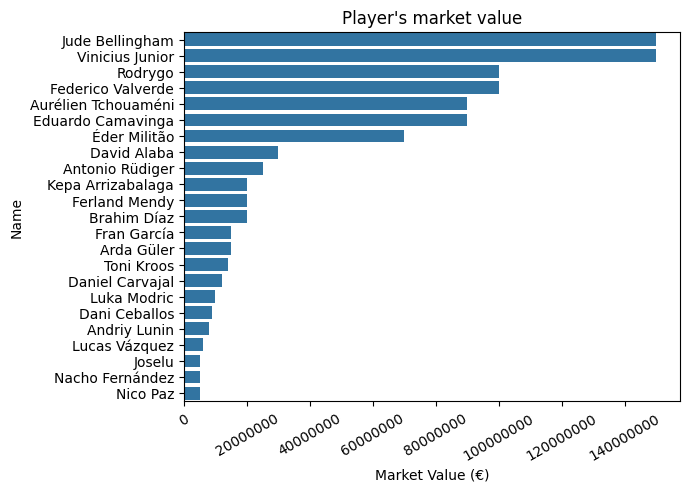


The most used XI of the season:



,name,country_of_citizenship,date_of_birth,sub_position,foot,height_in_cm,market_value_in_eur_y
16,Andriy Lunin,Ukraine,1999-02-11,Goalkeeper,right,191.0,8000000
3,David Alaba,Austria,1992-06-24,Centre-Back,left,180.0,30000000
5,Antonio Rüdiger,Germany,1993-03-03,Centre-Back,right,190.0,25000000
6,Daniel Carvajal,Spain,1992-01-11,Right-Back,right,173.0,12000000
1,Toni Kroos,Germany,1990-01-04,Central Midfield,right,183.0,14000000
13,Federico Valverde,Uruguay,1998-07-22,Central Midfield,right,182.0,100000000
18,Aurélien Tchouaméni,France,2000-01-27,Defensive Midfield,right,188.0,90000000
19,Jude Bellingham,England,2003-06-29,Attacking Midfield,right,186.0,150000000
4,Joselu,Spain,1990-03-27,Centre-Forward,right,191.0,5000000
14,Vinicius Junior,Brazil,2000-07-12,Left Winger,right,176.0,150000000


In [67]:
sns.barplot(data=players_current_season.sort_values(by='market_value_in_eur_y', ascending=False), x='market_value_in_eur_y', y='name', edgecolor="none")
def format_func(value, tick_number):
    return f'{value:.0f}'

pvl = plt.gca()
pvl.xaxis.set_major_formatter(ticker.FuncFormatter(format_func)) #This change to full display of number in x-axis

plt.xlabel('Market Value (€)')
plt.xticks(rotation=30)

plt.ylabel('Name')
plt.title("Player's market value")
plt.savefig("STarting XI's market value")
plt.show()

#XI
xi_id = appearances[(appearances['game_id'].isin(games_id))].groupby('player_id')['minutes_played'].sum(). \
        sort_values(ascending = False).index[:11].tolist()
xi = players_current_season[players_current_season['player_id'].isin(xi_id)].sort_values(by='position')[attribute]

print("\nThe most used XI of the season:\n")
xi

Goals and Assists's Analysis

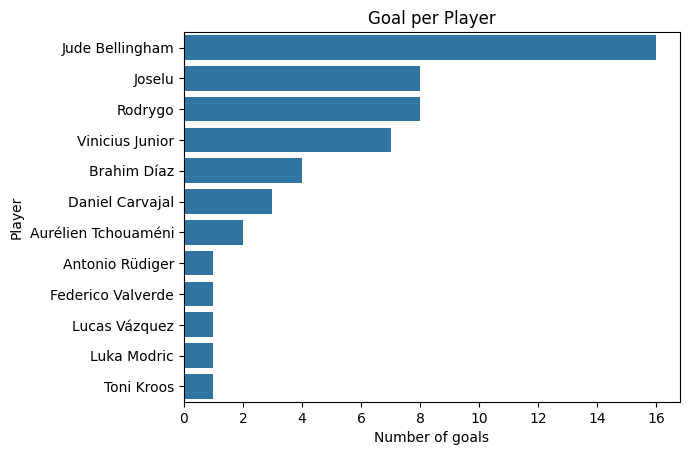

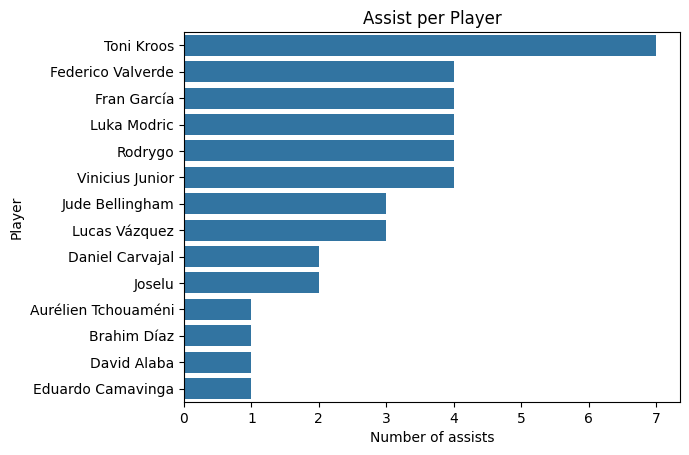

In [71]:
#Goals per Player
goal_assist = appearances.groupby('player_name')[['goals', 'assists']].sum()
goal = goal_assist[goal_assist['goals'] > 0].sort_values(by='goals', ascending = False).reset_index()
sns.barplot(data=goal, y='player_name', x='goals')
plt.title('Goal per Player')
plt.xlabel('Number of goals')
plt.ylabel('Player')
plt.savefig("Goal per player")
plt.show()

#Assists per Player
assist = goal_assist[goal_assist['assists'] > 0].sort_values(by='assists', ascending = False).reset_index()
sns.barplot(data=assist, y='player_name', x='assists')
plt.title('Assist per Player')
plt.xlabel('Number of assists')
plt.ylabel('Player')
plt.savefig("Assist per player")
plt.show()

In [79]:
goal_assist['total_contribution'] = goal_assist['goals'] + goal_assist['assists']
player_most_contribution = (goal_assist[goal_assist['total_contribution'] == goal_assist['total_contribution'].max()] \
                            [['player_name', 'total_contribution']].values.tolist())
player_most_contribution_list = [player[0] for player in player_most_contribution]

print(f"Player with the most goal contribution:")
for i in range(0, len(player_most_contribution)):
    print(f"{i+1}. {player_most_contribution[i][0]} with {player_most_contribution[i][1]} goals and assists")

Player with the most goal contribution:
1. Jude Bellingham with 19 goals and assists


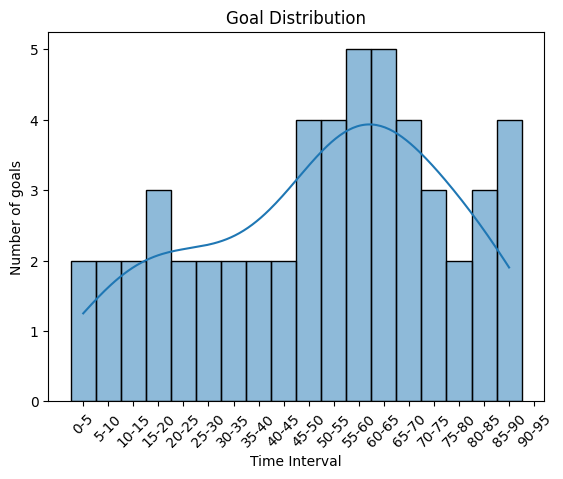

In [82]:
bins = list(range(0, 101, 5))
label = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95+']
game_events['interval'] = pd.cut(game_events['minute'], bins=bins, labels=label)
total_goals = club_games['own_goals'].sum()
goals = game_events[(game_events['type'] == 'Goals') & (game_events['club_id'] == club_id)]

sns.histplot(data=goals, x='interval', kde=True)
plt.title('Goal Distribution')
plt.ylabel('Number of goals')
plt.xlabel('Time Interval')
plt.xticks(rotation = 45)

plt.savefig("Goal Distribution")

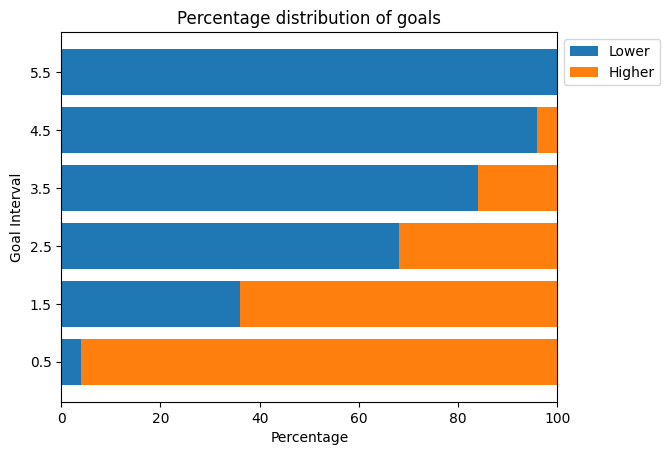

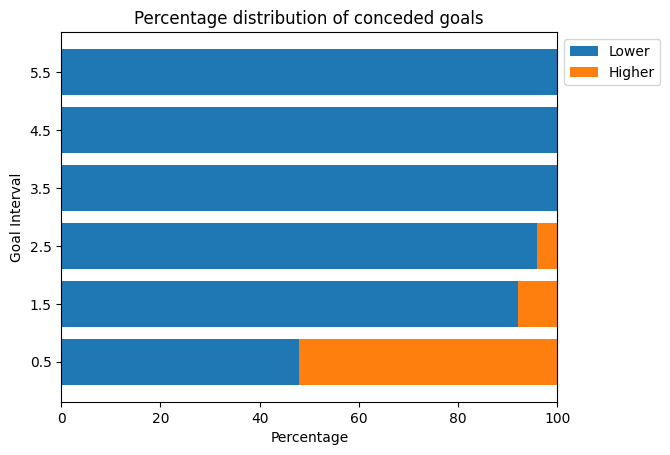

In [84]:
goal_col = club_games['own_goals']
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
bin_labels = ['0.5', '1.5', '2.5', '3.5', '4.5', '5.5']

# Calculate percentage distribution of total goals
lower = [np.sum(goal_col < bin) / len(goal_col) * 100 for bin in bins]
higher = [np.sum(goal_col > bin) / len(goal_col) * 100 for bin in bins]

fig, plot_percentage = plt.subplots()
plot_percentage.barh(bin_labels, lower, label='Lower')
plot_percentage.barh(bin_labels, higher, left=lower, label='Higher')

plot_percentage.set_xlabel('Percentage')
plot_percentage.set_ylabel('Goal Interval')
plot_percentage.set_title('Percentage distribution of goals')
plot_percentage.legend(bbox_to_anchor=(1, 1), loc='upper left')
fig.savefig("Percentage distribution of goals")

#Conceded Goals
conceed_col = club_games['opponent_goals']
lower = [np.sum(conceed_col < bin) / len(goal_col) * 100 for bin in bins]
higher = [np.sum(conceed_col > bin) / len(goal_col) * 100 for bin in bins]

figu, plot_percentages = plt.subplots()
plot_percentages.barh(bin_labels, lower, label='Lower')
plot_percentages.barh(bin_labels, higher, left=lower, label='Higher')

plot_percentages.set_xlabel('Percentage')
plot_percentages.set_ylabel('Goal Interval')
plot_percentages.set_title('Percentage distribution of conceded goals')
plot_percentages.legend(bbox_to_anchor=(1, 1), loc='upper left')
figu.savefig("Percentage distribution of conceded goals")

plt.show()


Real Madrid has a foreign rate of 65.22%



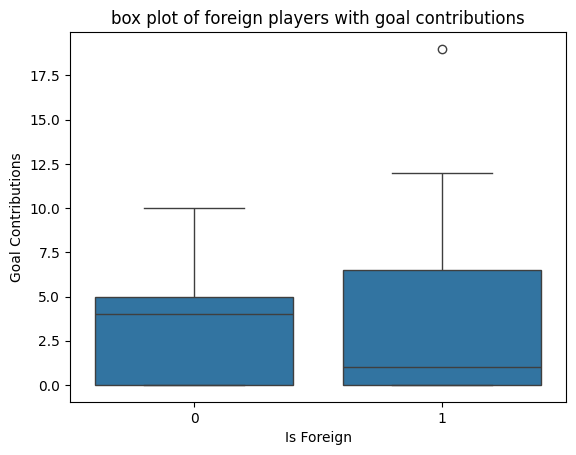

In [86]:
'''Foreigner Rate'''
foreign_rate = players_current_season[players_current_season['is_foreigner'] == 1]['is_foreigner'].sum()/ len(players_current_season) * 100
print(f'\n{club_name} has a foreign rate of {round(foreign_rate,2)}%\n')

'''box plot of foreign players with goal contributions'''
player_contribution = players_current_season.merge(goal_assist, left_on='name', right_on='player_name', how='left')
player_contribution['total_contribution'].fillna(0, inplace=True)

sns.boxplot(data=player_contribution, x='is_foreigner', y='total_contribution')
plt.xlabel('Is Foreign')
plt.ylabel('Goal Contributions')
plt.title("box plot of foreign players with goal contributions")

plt.savefig("box plot of foreign players with goal contributions")

In [90]:
'''points per match/ standing'''
results = {'win': 0, 'draw': 0, 'lose': 0}

# Check for wins, draws, and losses
for index, row in domestic_game.iterrows():
    if row['home_club_id'] == club_id:
        if row['home_club_goals'] > row['away_club_goals']:
            results['win'] += 1
        elif row['home_club_goals'] == row['away_club_goals']:
            results['draw'] += 1
        else:
            results['lose'] += 1
    elif row['away_club_id'] == club_id:
        if row['away_club_goals'] > row['home_club_goals']:
            results['win'] += 1
        elif row['away_club_goals'] == row['home_club_goals']:
            results['draw'] += 1
        else:
            results['lose'] += 1
print(f"Results in the season: {results}")

'''Home, Away results'''
home = {'win': 0, 'draw': 0, 'lose': 0}
for index, row in domestic_game.iterrows():
    if row['home_club_id'] == club_id:
        if row['home_club_goals'] > row['away_club_goals']:
            home['win'] += 1
        elif row['home_club_goals'] == row['away_club_goals']:
            home['draw'] += 1
        else:
            home['lose'] += 1
print(f"\nResults when playing at home: {home}")

away = {'win': 0, 'draw': 0, 'lose': 0}
for index, row in domestic_game.iterrows():
    if row['away_club_id'] == club_id:
        if row['away_club_goals'] > row['home_club_goals']:
            away['win'] += 1
        elif row['away_club_goals'] == row['home_club_goals']:
            away['draw'] += 1
        else:
            away['lose'] += 1
print(f"\nResults when playing away from home: {away}")

#Points per game
points_per_game = (results['win'] * 3 + results['draw']) / (results['win'] + results['draw'] + results['lose'])
print(f"\nAfter {results['win'] + results['draw'] + results['lose']} matches the team gets an average of {round(points_per_game, 2)} points per game")

#Clean sheets
club_games['clean_sheets'] = club_games['opponent_goals'].apply(lambda x: 1 if x == 0 else 0)
clean_sheets = club_games['clean_sheets'].sum()
print(f'\nThe club has {clean_sheets} matches where they conceeded no goal ({round(clean_sheets/len(club_games) * 100, 2)}%)')

Results in the season: {'win': 19, 'draw': 5, 'lose': 1}

Results when playing at home: {'win': 10, 'draw': 2, 'lose': 0}

Results when playing away from home: {'win': 9, 'draw': 3, 'lose': 1}

After 25 matches the team gets an average of 2.48 points per game

The club has 12 matches where they conceeded no goal (48.0%)


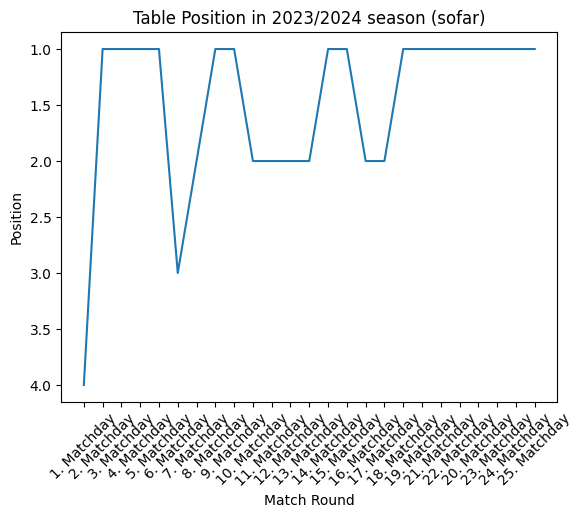

In [94]:
position = []
round = []
for index, row in domestic_game[['round','home_club_id', 'away_club_id', 'home_club_position', 'away_club_position']].iterrows():
    round.append(row['round'])
    if row['home_club_id'] == club_id:
        position.append(row['home_club_position'])
    elif row['away_club_id'] == club_id:
        position.append(row['away_club_position'])
        
plt.plot(round, position)
plt.gca().invert_yaxis()
plt.title(f'Table Position in {season}/{season+1} season (sofar)')

plt.xlabel('Match Round')
plt.xticks(rotation=45)

plt.ylabel('Position')
plt.savefig('Table Position in season (sofar)')

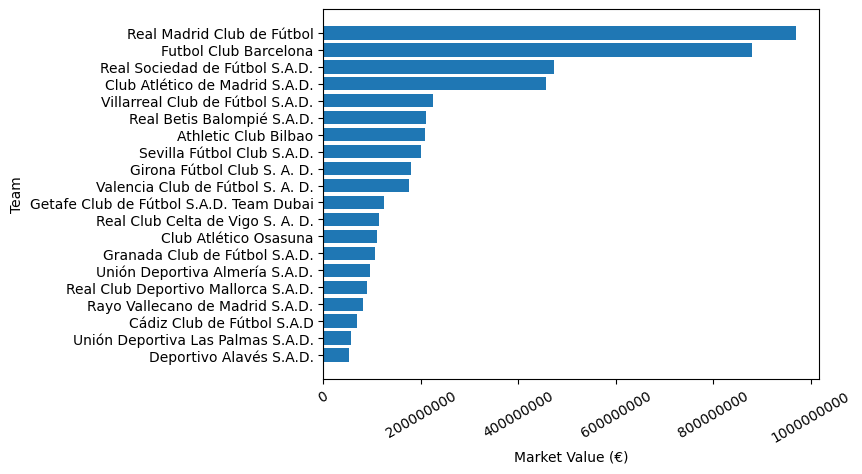

In [95]:
clubs_id = set(game[(game['competition_id'] == league_id) & (game['season'] == season)]['home_club_id'].tolist())
team_name = []
market_value = []

for id in clubs_id: #It displays the full market value for all team in that season
    team_name.append(club[club['club_id'] == id]['name'].iat[0])
    
    game_team = game[((game['home_club_id'] == id) | (game['away_club_id'] == id)) & (game['season'] == season)]
    gameid = game_team[game_team['competition_id'] == league_id].sort_values(by='round')['game_id'].tolist()
    app = appearance[(appearance['game_id'].isin(gameid)) & (appearance['player_club_id'] == id)]
    get_all = set(app['player_id'].to_list())
    players_current = players[players['player_id'].isin(get_all)]
    players_current['season_start'] = f'08 {season}'
    players_current = players_current.merge(player_value[['player_id', 'market_value_in_eur', 'month_year']], 
                    left_on=['season_start', 'player_id'], right_on=['month_year', 'player_id'])
    players_current.drop_duplicates(subset=['player_id'], inplace=True)
    
    market_value.append(players_current['market_value_in_eur_y'].sum())

team_name = [name.replace(" Football Club", "") for name in team_name] #Shorten the name but only applied for English club

#pair sort the team and their values
team_and_market_value = list(zip(team_name, market_value))
team_and_market_value.sort(key=lambda x: x[1])
team_name, market_value = zip(*team_and_market_value)

plt.barh(team_name, market_value)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.xlabel('Market Value (€)')
plt.xticks(rotation=30)

plt.ylabel('Team')
plt.savefig("Team market value in the league")

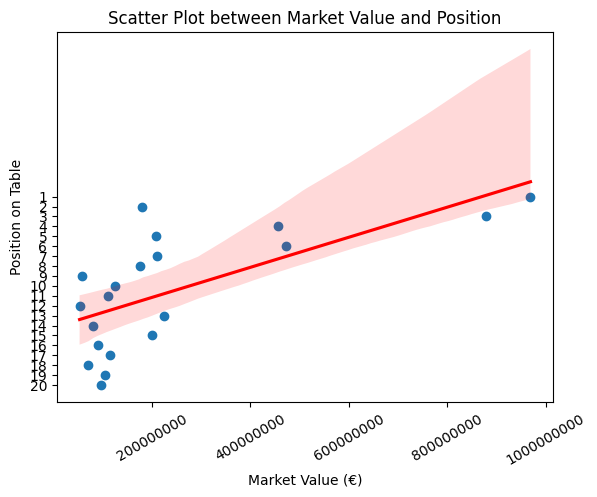

In [96]:
#Map team name and market value to 2 lists
league = game[(game['competition_id'] == league_id) & (game['season'] == season)]
last_current_round = league.sort_values(by='date', ascending=False)['round'].iat[0]
position_home = league[league['round'] == last_current_round][['home_club_name', 'home_club_position']].values.tolist()
position_away = league[league['round'] == last_current_round][['away_club_name', 'away_club_position']].values.tolist()
league_position = position_home + position_away

# Make the club name shorter (only for English clubs)
league_position = dict([[club[0].replace(" Football Club", ""), club[1]] for club in league_position])
team_and_market_value = dict([[club[0].replace(" Football Club", ""), club[1]] for club in team_and_market_value]) 

get_name = list(league_position.keys())
values = [team_and_market_value[club] for club in get_name]
positions = [int(league_position[club]) for club in get_name]

plt.scatter(values, positions)
sns.regplot(x=values, y=positions, scatter=False, color='red')
plot_value_pos = plt.gca()

plt.title('Scatter Plot between Market Value and Position')
plt.xlabel('Market Value (€)')
plt.xticks(rotation=30)# This is to make the position 1 appear at the top
plot_value_pos.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.ylabel('Position on Table')
plt.yticks(range(min(positions), max(positions) + 1))
plt.gca().invert_yaxis()

plt.savefig("Scatter Plot between Market Value and Position")

Cards and fouls analysis

In [97]:
apps = appearances[appearances['game_id'].isin(games_id)]
total_yellow = apps[apps['game_id'].isin(games_id)]['yellow_cards'].sum()
total_red = apps[apps['game_id'].isin(games_id)]['red_cards'].sum()
print(f"The team has received {total_yellow} yellow and {total_red} red cards")
print(f"\nThe team has received average {total_yellow/ len(club_games)} yellow cards per match")

The team has received 45 yellow and 2 red cards

The team has received average 1.8 yellow cards per match


In [103]:
#Player with most yellow cards
most_yellow = appearances.groupby('player_id')['yellow_cards'].sum()
no_yellow = most_yellow.max()
player_most_yellow_id = most_yellow[most_yellow == no_yellow].index.tolist()
player_most_yellow = players_current_season[attribute][players_current_season['player_id'].isin(player_most_yellow_id)]
player_most_yellow = player_most_yellow.assign(Number_of_yellow_cards=no_yellow)
print(f"Player with the most yellow cards:\n {player_most_yellow}\n")

#Player with most red cards
most_red = appearances.groupby('player_id')['red_cards'].sum().rename("sum")
no_red = most_red.max()
player_most_red_id = most_red[most_red == no_red].index.tolist()
player_most_red = players_current_season[attribute][players_current_season['player_id'].isin(player_most_red_id)]
player_most_red = player_most_red.assign(Number_of_red_cards=no_red)
print(f"Player with the most red cards:\n {player_most_red}\n")

Player with the most yellow cards:
               name country_of_citizenship date_of_birth sub_position   foot  \
5  Antonio Rüdiger                Germany    1993-03-03  Centre-Back  right   

   height_in_cm  market_value_in_eur_y  Number_of_yellow_cards  
5         190.0               25000000                       7  

Player with the most red cards:
               name country_of_citizenship date_of_birth sub_position   foot  \
2  Nacho Fernández                  Spain    1990-01-18  Centre-Back  right   

   height_in_cm  market_value_in_eur_y  Number_of_red_cards  
2         180.0                5000000                    2  



In [107]:
cards = game_events[(game_events['type'] == 'Cards') & (game_events['club_id'] == club_id)]
conditions = [(cards['description'].str.contains('Yellow card', case=False)), (cards['description'].str.contains('Red|Second yellow', case=False))]
choice = ['Yellow', 'Red']
cards['card_type'] = np.select(conditions, choice)

game_id_red_card = cards[cards['description'].str.contains('Red|Second yellow', case=False)]['game_id'].tolist()
game_red = games[games['game_id'].isin(set(game_id_red_card))]
df_ids = pd.DataFrame(game_id_red_card, columns=['id'])
df_ids['Number of cards'] = df_ids.groupby('id')['id'].transform('count')
df_ids = df_ids.drop_duplicates()
game_red = game_red.merge(df_ids, left_on='game_id', right_on='id')[['season', 'round', 'date', 'home_club_name', 'aggregate', 'away_club_name', 'Number of cards']]

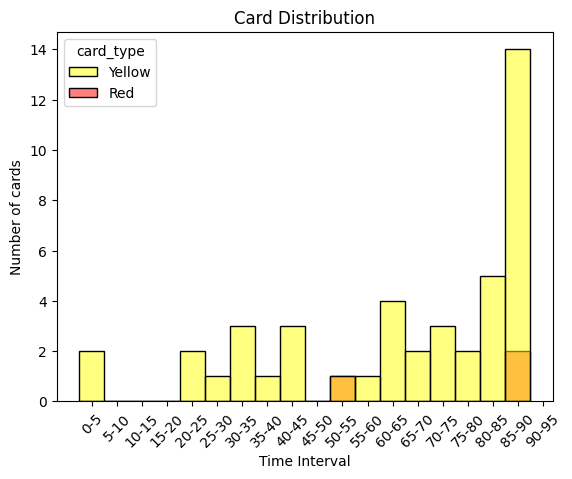

In [109]:
if not cards.empty:
    card_hist = sns.histplot(data=cards, x='interval', hue='card_type', palette=['yellow', 'red'])
    plt.title('Card Distribution')
    plt.ylabel('Number of cards')
    plt.xlabel('Time Interval')
    plt.xticks(rotation = 45)
    plt.savefig("Card Distribution")
else: pass

Analysis of Player with most contribution

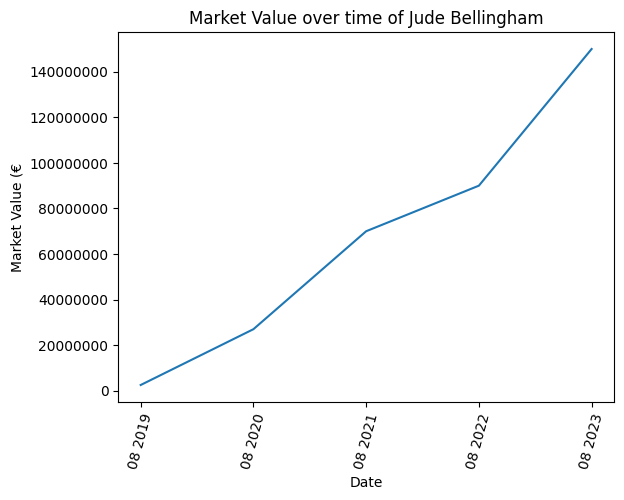

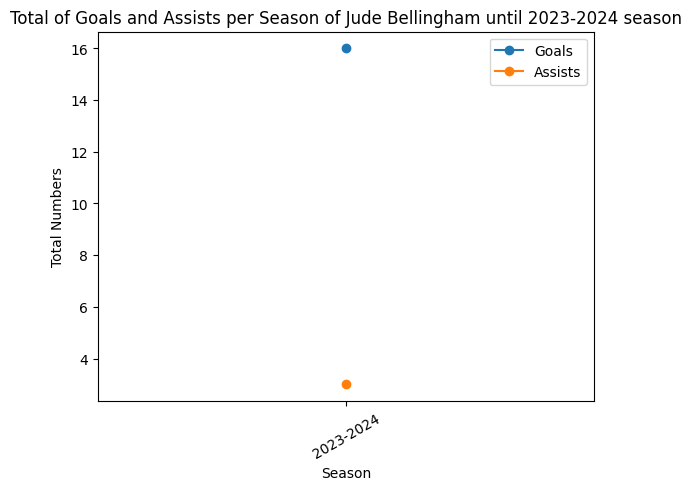

In [112]:
for player_most_contribution_name in player_most_contribution_list: #in case there are more than 1 player
    player_most_contribution_id = players_current_season[players_current_season['name'] == player_most_contribution_name]['player_id'].iat[0]
    #print(f"\n{players_current_season[players_current_season['name'] == player_most_contribution_name][attribute]}\n")
    
    #Market value over time until the analyzed season
    value_over_time = player_values[player_values['date'] <= f'{season+1}-06-30'] \
            .merge(players_current_season[players_current_season['name'] == player_most_contribution_name][['player_id', 'name']], on='player_id')
    sns.lineplot(data=value_over_time, x='month_year', y='market_value_in_eur')

    plt.xlabel('Date')
    plt.xticks(rotation=75)

    plt.ylabel('Market Value (€')
    value_time_plot = plt.gca()
    value_time_plot.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    plt.title(f'Market Value over time of {player_most_contribution_name}')
    plt.savefig("'Market Value over time of player_most_contribution_name")
    plt.show()


    #Reload apperances again to get stats of previous season
    #Get his game contributions
    his_data = appearance[(appearance['player_id'] == player_most_contribution_id) 
                    & (appearance['player_club_id'] == club_id)
                    & (appearance['competition_id'] == league_id)
                    & (appearance['season_start_year'] <= season)]
    
    his_contributions= his_data.groupby('season').agg({
        'goals': ['sum', 'mean'],
        'assists': ['sum', 'mean'],
        'yellow_cards': ['sum', 'mean'],
        'red_cards': ['sum', 'mean'],
        'minutes_played': ['sum', 'mean']
    }).reset_index()

    for column in ['goals', 'assists', 'yellow_cards', 'red_cards', 'minutes_played']:
        his_contributions[(column, 'mean')] = his_contributions[(column, 'mean')].round(2)
        
    goals_sum = his_contributions[('goals', 'sum')].tolist()
    assists_sum = his_contributions[('assists', 'sum')].tolist()
    seasons = his_contributions['season'].tolist()
    
    # Plot goals
    plt.plot(seasons, goals_sum, marker='o', label='Goals')

    # Plot assists
    plt.plot(seasons, assists_sum, marker='o', label='Assists')

    plt.xlabel('Season')
    plt.xticks(rotation=30)

    plt.ylabel('Total Numbers')
    plt.title(f'Total of Goals and Assists per Season of {player_most_contribution_name} until {season}-{season+1} season')
    plt.legend()

    plt.savefig("Total of Goals and Assists per Season of player_most_contribution_name until selected season")
    plt.show()